## Question 1: Convolution Operation (30 points)

#### I implement convolution and max pooling operations using separate functions.





In [1]:
import numpy as np
def Conv_Operation(x, conv_kernel, stride=1, padding=0, pad_value=0):
    if padding>0:
        x = np.pad(x,((padding,padding),(padding,padding)),'constant', constant_values = (pad_value,pad_value))
    h, w = x.shape
    f_h, f_w = conv_kernel.shape
    new_h = (h-f_h)//stride+1
    new_w = (w-f_w)//stride+1
    result = np.zeros((new_h, new_w ))
    for i in range(new_h):
        for j in range(new_w):
            block=x[i:i+f_h, j:j+f_w]
            result[i][j]+=(conv_kernel*block).sum()
    return result

def Maxpooling_Operation(x, pooling_size ,stride=1, padding=0, pad_value=0):
    if padding>0:
        x = np.pad(x,((padding,padding),(padding,padding)),'constant', constant_values = (pad_value,pad_value))
    h, w = x.shape
    new_h = (h-pooling_size)//stride+1
    new_w = (w-pooling_size)//stride+1
    result = np.zeros((new_h, new_w ))
    for i in range(new_h):
        for j in range(new_w):
            block=x[i:i+pooling_size, j:j+pooling_size]
            result[i][j]=np.max(block)
    return result

In [2]:
input_array = np.array([
    [0,2,4,1,0],
    [3,1,1,0,1],
    [2,4,1,0,1],
    [2,0,5,2,2],
    [0,1,3,2,1]
])
filter_array = np.array([
    [1,0,-1],
    [1,0,-1],
    [1,0,-1]
])

### Convolution with stride of 1

In [3]:
Conv_Operation(input_array, filter_array, stride=1)

array([[-1.,  6.,  4.],
       [ 0.,  3.,  3.],
       [-5.,  1.,  5.]])

### Zero padding of 1 + convolution with stride of 1

In [4]:
Conv_Operation(input_array, filter_array, stride=1, padding=1, pad_value=0)

array([[-3., -2.,  2.,  4.,  1.],
       [-7., -1.,  6.,  4.,  1.],
       [-5.,  0.,  3.,  3.,  2.],
       [-5., -5.,  1.,  5.,  4.],
       [-1., -6., -3.,  5.,  4.]])

### Zero padding of 2 + convolution with stride of 2

In [5]:
Conv_Operation(input_array, filter_array, stride=2, padding=2, pad_value=0)

array([[ 0., -2., -4.,  1.],
       [-3., -3., -2.,  2.],
       [-5., -7., -1.,  6.],
       [-7., -5.,  0.,  3.]])

### Convolution with stride of 1 + max pooling of 3 with stride of 1

In [6]:
y = Conv_Operation(input_array, filter_array, stride=1)
Maxpooling_Operation(y, pooling_size=3, stride=1)

array([[6.]])

### Zero padding of 2 + convolution with stride of 1 + max pooling of 3 with stride of 1

In [7]:
y = Conv_Operation(input_array, filter_array, stride=1, padding=2, pad_value=0)
Maxpooling_Operation(y, pooling_size=3, stride=1)

array([[0., 6., 6., 6., 4.],
       [0., 6., 6., 6., 4.],
       [0., 6., 6., 6., 5.],
       [0., 3., 5., 5., 5.],
       [0., 1., 5., 5., 5.]])

# Question 2: Image Classification using CNN in Pytorch (70 points)

In [8]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

#### Below are some hyperparameters. It is advisable to place them uniformly at the top of the document for ease of modification.

In [9]:
seed=42
batch_size=64
num_epochs=10


## (b) Data Exploration Pick one example from each digit and visualize them. Count the number of samples per digit in the original training data. Is the data distribution balanced?
#### I will first address question 2(b) because, following the typical modeling process, it is necessary to conduct preliminary data analysis upon receiving the data. It is notable that the data obtained from the file 'x_train.npy' has dimensions of (60000, 784), so I will first resize it to (60000, 28, 28).

The original dimension: (60000, 784)
The new dimension: (60000, 28, 28)


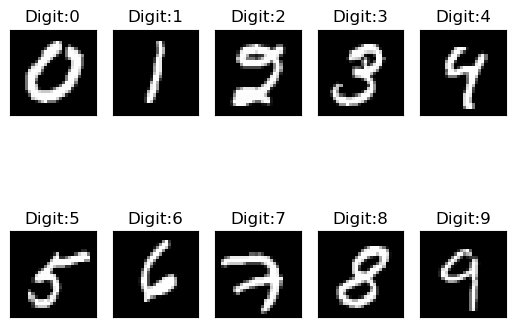

The number of samples for digit 0~9 are [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
The number of samples is : 60000


In [10]:
img_train=np.load('x_train.npy')
print(f'The original dimension: {img_train.shape}')
img_train.resize(img_train.shape[0], 28, 28)
print(f'The new dimension: {img_train.shape}')

label_train=np.load('y_train.npy')
x_test = np.load('x_test.npy')
number_of_class = []
example_of_data=[]
for i in range(10):
    tmp = np.where(label_train == i)[0]
    number_of_class.append(len(tmp))
    example_of_data.append(img_train[tmp[0]])


for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example_of_data[i], cmap='gray', interpolation='none')
    plt.title("Digit:{}".format(i))
    plt.xticks([])
    plt.yticks([])
plt.show()
print(f'The number of samples for digit 0~9 are {number_of_class}')
print(f'The number of samples is : {sum(number_of_class)}')

#### The distribution of the training set is not perfectly balanced, with a difference of 1321 samples between the class with the highest and lowest counts. With a total of 60,000 samples across 10 classes, the average count per class is 6000. It is notable that the sample counts for each class fall within the range of 5000 to 7000, which is relatively close to the average. Therefore, the distribution of the training set can be considered relatively balanced.

## (c) Data Split Split original training data into 80% for training and 20% validation datasets.

#### Next, I will address question 2(c) by partitioning the dataset. This will facilitate subsequent data loading tasks.

In [11]:
x_train,x_val,y_train,y_val=train_test_split(img_train,label_train,test_size=0.2,random_state=seed)
print(f'The training set contains {len(x_train)} samples, while the validation set contains {len(x_val)} samples.')

The training set contains 48000 samples, while the validation set contains 12000 samples.


## (a) Dataloader Download the MNIST train and test dataset on Canvas. Implement a dataloader with batch size and validation size as arguments.

#### Next, I address question2(a). I will begin by implementing a class for the Dataset.

In [12]:
class My_dataset(Dataset):
    def __init__(self,imgs, labels, transform=None):
        self.data = imgs.astype(np.float32)
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        each_data = self.data[idx]
        each_label = self.label[idx]
        each_data = self.transform(each_data)
        return each_data, each_label


transform = transforms.Compose([
    transforms.ToTensor(),
    ])

#### Next, I use the DataLoader to load the data, with the batch size defined as a hyperparameter at the beginning of this document. The default batch size is 64, and I print it five times to confirm its value

In [13]:
train_dataset = My_dataset(x_train, y_train, transform=transform)
val_dataset = My_dataset(x_val,y_val, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                                    pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False,
                                    pin_memory=True)

for idx, (images, labels) in enumerate(train_dataloader):
    print(f"batch#={idx}, X.shape={images.shape}; y.shape={labels.shape}")
    if idx >= 4:
        break

batch#=0, X.shape=torch.Size([64, 1, 28, 28]); y.shape=torch.Size([64])
batch#=1, X.shape=torch.Size([64, 1, 28, 28]); y.shape=torch.Size([64])
batch#=2, X.shape=torch.Size([64, 1, 28, 28]); y.shape=torch.Size([64])
batch#=3, X.shape=torch.Size([64, 1, 28, 28]); y.shape=torch.Size([64])
batch#=4, X.shape=torch.Size([64, 1, 28, 28]); y.shape=torch.Size([64])


## (d) Modeling Implement a convolutional neural network to classify the digits in the MNIST dataset. Experiment with at least 3 hyperparameters. You may experiment with different CNN hyper-parameters, e.g. num of layers, filter size, stride, activation function, dropout, weight regularization, etc. Use the validation data to decide which combination of hyperparameters is best. Report the final classification accuracy on the validation dataset.

#### I first implement a convolutional neural network. Then, I experiment with different configurations by varying the filter size, activation function, and adding dropout layers to evaluate the performance of different models.

In [14]:
class Conv_Net(nn.Module):
    def __init__(self, filter_size = 3, dropout = False, activate = 'relu'):
        super(Conv_Net, self).__init__()
        
        pad_size = filter_size // 2
        self.conv1 = nn.Conv2d(1, 64, kernel_size=filter_size, stride=1, padding=pad_size)
        self.act1 = nn.ReLU() if activate == 'relu' else nn.Sigmoid()
        self.drop1 = nn.Dropout(p=0.5) if dropout else nn.Identity()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=filter_size, stride=1, padding=pad_size)
        self.act2 = nn.ReLU() if activate == 'relu' else nn.Sigmoid()
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)

        self.fc1 = nn.Linear(14 * 14 * 128, 1024)
        self.act3 = nn.ReLU() if activate == 'relu' else nn.Sigmoid()
        self.drop2 = nn.Dropout(p=0.5) if dropout else nn.Identity()
        self.fc2 = nn.Linear(1024, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.drop2(x)
        x = self.fc2(x)

        return x

#### Define a training function. At the beginning of training, set a fixed random seed to ensure more precise comparison of the performance of different models.





In [15]:
def train(seed, model, train_loader, val_loader, epochs=15 ):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        print(f"epoch {epoch}")
        for i, (images, labels) in enumerate(tqdm(train_dataloader)):
            
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in tqdm(val_dataloader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f'The classification accuracy of the network on the {total} test images is {100 * correct / total} %')

#### I set the filter size to 3 and use the ReLU activation function without adding dropout layers. It is worth noting that after each training session, I transfer the model from the GPU to the CPU to prevent potential memory issues during subsequent training

In [16]:
model_1 = Conv_Net(filter_size=3, dropout=False, activate='relu')
train(seed, model_1, train_dataloader, val_dataloader, epochs=num_epochs)
model_1.cpu()

epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 208.07it/s]


The classification accuracy of the network on the 12000 test images is 98.13333333333334 %
epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 232.18it/s]


The classification accuracy of the network on the 12000 test images is 98.51666666666667 %
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 231.90it/s]


The classification accuracy of the network on the 12000 test images is 98.65833333333333 %
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 233.33it/s]


The classification accuracy of the network on the 12000 test images is 98.61666666666666 %
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 233.19it/s]


The classification accuracy of the network on the 12000 test images is 98.63333333333334 %
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 233.19it/s]


The classification accuracy of the network on the 12000 test images is 98.65833333333333 %
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 220.24it/s]


The classification accuracy of the network on the 12000 test images is 98.79166666666667 %
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 214.10it/s]


The classification accuracy of the network on the 12000 test images is 98.89166666666667 %
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 238.21it/s]


The classification accuracy of the network on the 12000 test images is 98.65833333333333 %
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 240.18it/s]


The classification accuracy of the network on the 12000 test images is 98.55 %


Conv_Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Identity()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (act3): ReLU()
  (drop2): Identity()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

#### The accuracy on the validation set for the first configuration is 98.55%. Next I set the filter size to 5, keeping all other parameters unchanged.





In [17]:
model_2 = Conv_Net(filter_size=5, dropout=False, activate='relu')
train(seed, model_2, train_dataloader, val_dataloader, epochs=num_epochs)
model_2.cpu()

epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 181.32it/s]


The classification accuracy of the network on the 12000 test images is 98.275 %
epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 181.49it/s]


The classification accuracy of the network on the 12000 test images is 98.60833333333333 %
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 181.32it/s]


The classification accuracy of the network on the 12000 test images is 98.8 %
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 182.37it/s]


The classification accuracy of the network on the 12000 test images is 98.78333333333333 %
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 179.42it/s]


The classification accuracy of the network on the 12000 test images is 98.85833333333333 %
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 181.58it/s]


The classification accuracy of the network on the 12000 test images is 98.75 %
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 181.41it/s]


The classification accuracy of the network on the 12000 test images is 98.725 %
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 183.80it/s]


The classification accuracy of the network on the 12000 test images is 98.95 %
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 172.67it/s]


The classification accuracy of the network on the 12000 test images is 99.14166666666667 %
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 164.38it/s]

The classification accuracy of the network on the 12000 test images is 98.83333333333333 %


Conv_Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (drop1): Identity()
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (act3): ReLU()
  (drop2): Identity()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

#### The second configuration achieves an accuracy of 98.833% on the validation set, which is higher than the previous best. Therefore, the optimal configuration is now: filter_size=5, dropout=False, activation='relu'. Next, I will change the activation function to nn.Sigmoid().

In [18]:
model_3 = Conv_Net(filter_size=5, dropout=False, activate='sigmoid')
train(seed, model_3, train_dataloader, val_dataloader, epochs=num_epochs)
model_3.cpu()

epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 178.99it/s]


The classification accuracy of the network on the 12000 test images is 10.141666666666667 %
epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 182.37it/s]


The classification accuracy of the network on the 12000 test images is 11.375 %
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 179.42it/s]


The classification accuracy of the network on the 12000 test images is 9.95 %
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 182.73it/s]


The classification accuracy of the network on the 12000 test images is 10.141666666666667 %
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 174.35it/s]


The classification accuracy of the network on the 12000 test images is 9.425 %
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 159.11it/s]


The classification accuracy of the network on the 12000 test images is 9.95 %
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 181.15it/s]


The classification accuracy of the network on the 12000 test images is 10.141666666666667 %
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 176.39it/s]


The classification accuracy of the network on the 12000 test images is 11.375 %
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 175.49it/s]


The classification accuracy of the network on the 12000 test images is 9.491666666666667 %
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 168.58it/s]

The classification accuracy of the network on the 12000 test images is 10.291666666666666 %


Conv_Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Sigmoid()
  (drop1): Identity()
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (act3): Sigmoid()
  (drop2): Identity()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

#### The third configuration achieves an accuracy of only 10.292% on the validation set, which is significantly lower than the previous results. Therefore, the optimal parameter settings remain unchanged: filter_size=5, dropout=False, activation='relu'. Next, I will add a dropout layer.





In [19]:
model_4 = Conv_Net(filter_size=5, dropout=True, activate='relu')
train(seed, model_4, train_dataloader, val_dataloader, epochs=num_epochs)
model_4.cpu()

epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 178.99it/s]


The classification accuracy of the network on the 12000 test images is 97.36666666666666 %
epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 175.00it/s]


The classification accuracy of the network on the 12000 test images is 97.88333333333334 %
epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 178.99it/s]


The classification accuracy of the network on the 12000 test images is 98.18333333333334 %
epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 179.76it/s]


The classification accuracy of the network on the 12000 test images is 98.3 %
epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 168.50it/s]


The classification accuracy of the network on the 12000 test images is 98.23333333333333 %
epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 163.74it/s]


The classification accuracy of the network on the 12000 test images is 98.36666666666666 %
epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 173.31it/s]


The classification accuracy of the network on the 12000 test images is 98.53333333333333 %
epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 170.66it/s]


The classification accuracy of the network on the 12000 test images is 98.175 %
epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 179.59it/s]


The classification accuracy of the network on the 12000 test images is 98.64166666666667 %
epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 178.57it/s]

The classification accuracy of the network on the 12000 test images is 98.375 %


Conv_Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (act3): ReLU()
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

#### The fourth configuration yields an accuracy of 98.375% on the validation set, which does not surpass the previous best result. Consequently, the optimal parameter settings remain unchanged, being: filter_size=5, dropout=False, activation='relu'.





#### In conclusion, the optimal configuration is filter_size=5, dropout=False, activation='relu', under which the model achieves an accuracy of 98.833% on the validation set.

## (g) Inference Use the best fine-tuned model for inference on the test dataset. Save your predictions for every row of the test data in a CSV file with the name FirstName LastName Preds.csv(Do not shuffle the test data)

In [20]:
import csv
f = open("Chonglin_Zhang_Preds.csv",'w',encoding='UTF-8', newline='')
writer = csv.writer(f)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_2.to(device)
model_2.eval()
for i,each_test_data in enumerate(tqdm(x_test)):
    each_test_data = transform(each_test_data.astype(np.float32)).unsqueeze(0)
    each_test_data = each_test_data.to(device)
    result = model_2(each_test_data)
    _, pred = torch.max(result.data, 1)
    writer.writerow(str(pred.item()))
f.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 563.95it/s]


## BONUS: Filter Visualization Randomly pick an image from the training set. Visualize the feature maps corresponding to all convolution filters after the first and last convolution layers.s.

#### First, print the structure of the model. Since the model consists of two convolutional layers, I extract the outputs from these two layers.





In [21]:
name_list=[]
for (name, module) in model_2.named_modules():
    name_list.append(name)
print(name_list)
print(model_2)

['', 'conv1', 'act1', 'drop1', 'conv2', 'act2', 'pool', 'fc1', 'act3', 'drop2', 'fc2']
Conv_Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (drop1): Identity()
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (act3): ReLU()
  (drop2): Identity()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


In [22]:
import torchvision
extract_model = torchvision.models._utils.IntermediateLayerGetter(model_2,{'conv1': 'first_conv_layer', 'conv2': 'last_conv_layer'})
import random
choice_sample = img_train[random.randint(0,len(img_train)-1)]
choice_sample = transform(choice_sample.astype(np.float32)).unsqueeze(0).to(device)
result = extract_model(choice_sample)


#### The first layer's feature map comprises 64 channels.





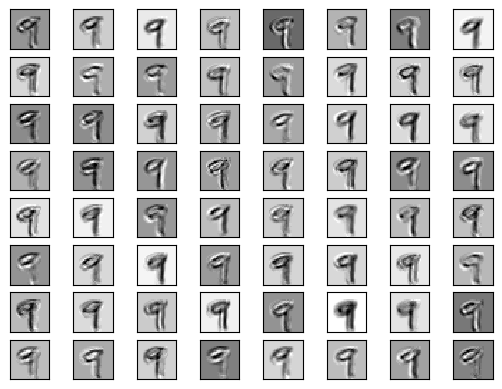

In [23]:
first_feature_map = result['first_conv_layer'].squeeze(0).cpu().detach().numpy()
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(first_feature_map[i], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

#### The last layer's feature map comprises 128 channels.



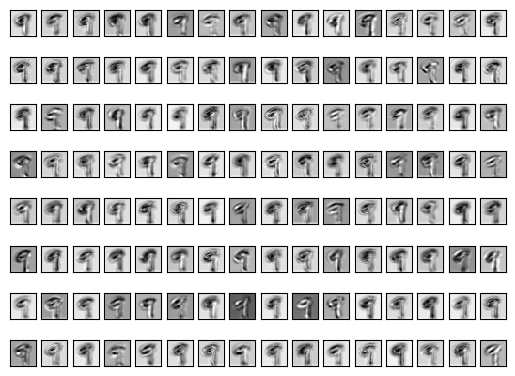

In [24]:
last_feature_map = result['last_conv_layer'].squeeze(0).cpu().detach().numpy()
for i in range(128):
    plt.subplot(8, 16, i + 1)
    plt.imshow(last_feature_map[i], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()